# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install requirements

In [2]:
!pip install pytorch_lightning
!pip install timm

     |████████████████████████████████| 527 kB 4.2 MB/s 
     |████████████████████████████████| 397 kB 33.5 MB/s 
     |████████████████████████████████| 829 kB 44.5 MB/s 
     |████████████████████████████████| 596 kB 46.3 MB/s 
     |████████████████████████████████| 133 kB 50.8 MB/s 
     |████████████████████████████████| 952 kB 35.8 MB/s 
     |████████████████████████████████| 1.1 MB 41.3 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 57.0 MB/s 
     |████████████████████████████████| 271 kB 55.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=2c9fccde4d15db75a62b0a12813e0aee7b67feaeddfcd3823abaa2e464f49ea0
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

     |████████████████████████████████| 431 kB 4.3 MB/s 


# Import relevant libraries

In [3]:
import sys
import os
module_path = os.path.join(os.path.abspath(''), "drive/MyDrive/Master_Thesis_Profactor/zdmp/")
if module_path not in sys.path:
  sys.path.append(module_path)

import zdmp
from utils.lightning_classifier import Classifier

import timm
import torch
import torchvision
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import numpy as np

In [ ]:

def save_model(model, name):
    path = os.path.join(
        "/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights",
        f"{name}.pth.tar"
    )
    torch.save(model.state_dict(), path)

# Available models

* 0 - luna
* 1 - alexnet
* 2 - resnet
* 3 - convnext
* 4 - efficientnetv2

In [ ]:
model_names = ["luna", "alexnet", "resnet", "convnext", "efficientnetv2"]
model_name = model_names[3]

## Prepare the Dataset and Dataloader

In [4]:
# Make the results reproducible
pl.seed_everything(42)

# Prepare dataset
ds_train = zdmp.get_train_data()
ds_test = zdmp.get_test_data()

# Prepare Dataloaders
dl_train = DataLoader(ds_train, batch_size=32, num_workers=2, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=32, num_workers=2)

Global seed set to 42


zdmp - ViT size - False
get_data - ViT size - False
transform - ViT size - False


## Prepare the selected model

In [ ]:
# Prepare model
if model_name == "luna":
    model = zdmp.get_luna(pretrained=False)
if model_name == "alexnet":
    model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    model.classifier[6] = torch.nn.Linear(4096, 2)
elif model_name == "resnet":
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    model.fc = torch.nn.Linear(512, 2)
elif model_name == "convnext":
    model = timm.models.convnext.convnext_tiny(pretrained=True)
    model.head.fc = torch.nn.Linear(768, 2)
elif model_name == "efficientnetv2":
    model = timm.models.efficientnetv2_rw_s(pretrained=True)
    model.classifier = torch.nn.Linear(1792, 2)

### Train in this cell or load pretrained weights for the casting dataset in the next cell

In [ ]:
# Prepare Classifier to train the model
classifier = Classifier(model)

# Criteria to stop early
#early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5)

# Prepare the Trainer
trainer = pl.Trainer(gpus=1, max_epochs=3)
#trainer = pl.Trainer(gpus=1, min_epochs=25, max_epochs=100)

# Find the best learning rate
#trainer.tune(classifier, train_dataloaders=dl_train, val_dataloaders=dl_test)

# Train
trainer.fit(classifier, dl_train, dl_test)

# Save the trained weights
save_model(classifier.model, model_name)

Global seed set to 42


zdmp - ViT size - False
get_data - ViT size - False
transform - ViT size - False


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_v2s_ra2_288-a6477665.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2s_ra2_288-a6477665.pth
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EfficientNet     | 22.2 M
1 | train_metrics | MetricCollection | 0     
2 | valid_metrics | MetricCollection | 0     
---------------------------------------------------
22.2 M    Trainable params
0         Non-trainable params
22.2 M    Total params
88.608    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Load weights

In [ ]:
path_weights = f"/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/{model_name}.pth.tar"
if os.path.isfile(path_weights):
    model.load_state_dict(torch.load(path_weights))
else:
    print("Weights file not found")

# Tensorboard

This cell will only work if a model has been trained during the current runtime.

Metrics for both train and validation:
* Accuracy
* Precission
* Recall
* Loss

In [ ]:
!tensorboard dev upload --logdir '/content/lightning_logs'

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/ubKwkJGhQBKCrNv7da2Jnw/

[2022-02-12T13:24:18] Started scanning logdir.
[2022-02-12T13:24:19] Total uploaded: 154 scalars, 12 tensors (72 B), 0 binary objects
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 258, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/pyth

# Test trained model

In [ ]:
wrong = 0
w = "*"*10
r = ""
for i, (img, lbl) in enumerate(ds_test):
    out_ = model(img.unsqueeze(0)).softmax(1)
    out = int(out_.softmax(1).argmax())
    if out != lbl:
        wrong+=1
    print(f"{i}\tPred: {out}\tTrue:{lbl}\t{out_}\t{r if out==lbl else w}")
print(f"Wrong: {wrong}/{len(ds_test)}")

0	Pred: 1	True:1	tensor([[0.0075, 0.9925]], grad_fn=<SoftmaxBackward0>)	
1	Pred: 1	True:1	tensor([[0.0724, 0.9276]], grad_fn=<SoftmaxBackward0>)	
2	Pred: 1	True:1	tensor([[0.0026, 0.9974]], grad_fn=<SoftmaxBackward0>)	
3	Pred: 1	True:1	tensor([[0.0031, 0.9969]], grad_fn=<SoftmaxBackward0>)	
4	Pred: 0	True:0	tensor([[0.9989, 0.0011]], grad_fn=<SoftmaxBackward0>)	
5	Pred: 0	True:0	tensor([[9.9944e-01, 5.6303e-04]], grad_fn=<SoftmaxBackward0>)	
6	Pred: 0	True:0	tensor([[9.9935e-01, 6.4519e-04]], grad_fn=<SoftmaxBackward0>)	
7	Pred: 0	True:0	tensor([[0.9982, 0.0018]], grad_fn=<SoftmaxBackward0>)	
8	Pred: 1	True:1	tensor([[0.0031, 0.9969]], grad_fn=<SoftmaxBackward0>)	
9	Pred: 0	True:0	tensor([[9.9911e-01, 8.8644e-04]], grad_fn=<SoftmaxBackward0>)	
10	Pred: 0	True:0	tensor([[9.9912e-01, 8.8431e-04]], grad_fn=<SoftmaxBackward0>)	
11	Pred: 1	True:1	tensor([[0.0054, 0.9946]], grad_fn=<SoftmaxBackward0>)	
12	Pred: 0	True:0	tensor([[9.9945e-01, 5.5130e-04]], grad_fn=<SoftmaxBackward0>)	
13	Pred:

KeyboardInterrupt: ignored

# SHAP

## Install and import

In [ ]:
!pip install shap
import shap

## Using shap

In [ ]:
batch = next(iter(dl_train))
imgs, _ = batch

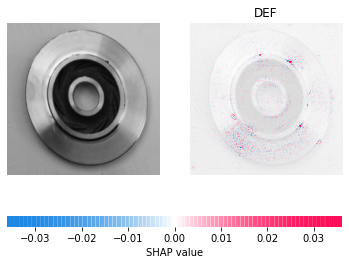

In [ ]:
classes = ["DEF", "OK"]
mean = torch.tensor([0.3460, 0.4832, 0.7033])
std = torch.tensor([1.0419, 1.0652, 1.0605])

e = shap.GradientExplainer(model, imgs)

img = ds_test[4][0]

shap_values,indexes = e.shap_values(img.unsqueeze(0), ranked_outputs=1, nsamples=50)
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
index_names = np.vectorize(lambda x: classes[x])(indexes)
shap.image_plot(shap_values, 
    ((img 
      * std[:, None, None] 
      + mean[:, None, None])).permute(1, 2, 0).unsqueeze(0).numpy(), 
    index_names)


TypeError: ignored

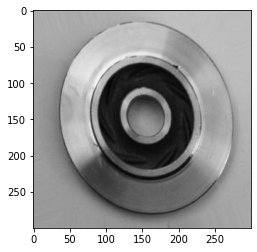

In [ ]:
plt.imshow(((img
                  * std[:, None, None] 
                  + mean[:, None, None])).permute(1, 2, 0).numpy())
x, y, rgb = np.where(shap_values[0][0]>0.01)
plt.scatter(x, y, s=15, c='r', alpha=[a for a in shap_values[0][0][x,y,rgb]])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
[print(a if isinstance(a, float) else 0) for a in shap_values[0][0][x,y,rgb]]

0.015539911733581104
0.013163499147866204
0.016637851025267617
0.027975334792233644
0.04019961791180633
0.02927689563874168
0.04559775184901334
0.022652709845097086
0.0340600415991055
0.011886873231868149
0.010889153034938037
0.018830498470276447
0.012544770839195035
0.010484055262831441
0.010945239024493285
0.012602894938290081
0.013253954510889723
0.011027869410047903
0.017872304784737735
0.011530209487398677
0.0173482123048334
0.013565912325811568
0.01001556535096849
0.01688620000227089
0.02102659114494097
0.011896840060563674
0.011815529744563211
0.03972432225447006
0.018159871447888856
0.03656640661595125
0.027260659248769446
0.01548552753031739
0.04011998468677846
0.014938297753205616
0.012443051901022857
0.012084226049942061
0.05355727149002651
0.048364886254906335
0.05588017211068031
0.027899728777161164
0.06276553074823106
0.030957060625299748
0.05563728516727878
0.10700682452843907
0.03355403789388438
0.08589749530553817
0.02174219697940589
0.024135647420720677
0.024002955619

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
shap_values[0][0][x,y,rgb]

0.011376886485051587

In [6]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests
import torch
import timm

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download&id="+id+"&confirm=t"
    session = requests.Session()
    response = session.get(URL)
    save_response_content(response, destination)
    
def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)



file_id = '1eTbkcFYrxbSxJ4Jj0BpH1_mbLqJQ0LmP'
destination = '/content/sample_data/convnext.pth.tar'
download_file_from_google_drive(file_id, destination)

model = timm.models.convnext.convnext_tiny()
model.head.fc = torch.nn.Linear(768,2)

model.load_state_dict(torch.load(destination))


<All keys matched successfully>

In [13]:
img, lbl = ds_test[60]

out = model(img.unsqueeze(0)).softmax(1).argmax()

print(lbl, out)

1 tensor(1)


In [15]:
state_dict = torch.hub.load_state_dict_from_url("https://docs.google.com/uc?export=download&id=1eTbkcFYrxbSxJ4Jj0BpH1_mbLqJQ0LmP&confirm=t")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
%pip install timm

In [16]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)


Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]